In [1]:
%matplotlib inline


Fit Multiple Data Sets
======================

Fitting multiple (simulated) Gaussian data sets simultaneously.

All minimizers require the residual array to be one-dimensional. Therefore, in
the ``objective`` we need to ```flatten``` the array before returning it.

TODO: this should be using the Model interface / built-in models!


In [1]:
import matplotlib.pyplot as plt
import numpy as np

import lmfit
from lmfit import Parameters, minimize, report_fit

In [103]:
def chi(x, ld, tg, f):
    """Gaussian lineshape."""
    return np.exp(-x / ld * np.sqrt(1 +  1j * tg * 2 * np.pi * f))


def chi_dataset(params, i, x):
    """Calculate Gaussian lineshape from parameters for data set."""
    ld = params['ld_%i' % (i+1)]
    tg = params['tg_%i' % (i+1)]
    f = params['f_%i' % (i+1)]
    return chi(x, ld, tg, f)


def objective_single(params, x, data):
    """Calculate total residual for fits of Gaussians to several data sets."""
    ndata = data.shape[0]
    resid = 0.0*data[:]

    resid_c = []
    # make residual per data set
    for i in range(ndata):
        resid[i, :] = data[i, :] - chi_dataset(params, i, x)
        if resid[i].dtype == np.complex:
            resid_c.append(resid[i].ravel().view(np.float))
#         print(np.shape(resid))
    # now flatten this to a 1D array, as minimize() needs
    resid_c = np.array(resid_c)
    return resid_c.flatten()

def objective_multiple(params, x, data):
    """Calculate total residual for fits of Gaussians to several data sets."""
    ndata = data.shape[0]
    resid = 0.0*data[:]

    resid_c = []
    # make residual per data set
    for i in range(ndata):
#         print(resid[i].shape)
        resid[i] = data[i] - chi_dataset(params, i, x[i])
        if resid[i].dtype == np.complex:
            resid_c.append(resid[i].ravel().view(np.float))
#         print(np.shape(resid))
    # now flatten this to a 1D array, as minimize() needs
    resid_c = np.array(resid_c)
    return np.concatenate(resid_c).ravel()

Create five simulated Gaussian data sets



In [137]:
# Simulating data with a single x array
np.random.seed(121)

x = np.linspace(0, 30 ,40)

data = []
for i in np.arange(2):
    params = Parameters()
    ld = 10 + 30*np.random.rand()
    tg = 1 + 20*np.random.rand()
    f = 2 * i + 1
    dat = chi(x, ld, tg, f) + np.random.normal(size=x.size, scale=0.001)
    data.append(dat)
    print(ld, tg, f)
data = np.array(data)

13.339924840157332 5.215351490856618 1
25.351417130035937 19.761681356341203 3


In [275]:
# Simulating data with multiple x arrays
np.random.seed(121)

x = []
x.append(np.linspace(0, 20 ,20))
x.append(np.linspace(0, 20 ,40))
x.append(np.linspace(0, 10 ,20))
# x.append(np.linspace(0, 15 ,30))
# print(x)
data = []
for i in np.arange(3):
    params = Parameters()
    ld = 10 + 30*np.random.rand()
    tg = 1 + 2.5*np.random.rand()
    f =  i + 1
    dat = chi(x[i], ld, tg, f) + np.random.normal(size=x[i].size, scale=0.001)
    data.append(dat)
    print(ld, tg, f, 2*np.pi*f*tg)
data = np.array(data)

13.339924840157332 1.5269189363570772 1 9.593914626173069
38.40815479205783 2.840808440909215 2 35.69865171286505
31.310330025374174 3.435784841848091 3 64.7630185107908


Create five sets of fitting parameters, one per data set



In [134]:
fit_params = Parameters()
for iy, y in enumerate(data):
    fit_params.add('ld_%i' % (iy+1), value=20, min=0.0, max=200)
    fit_params.add('tg_%i' % (iy+1), value=3, min=0.01, max=100.0)
    fit_params.add('f_%i' % (iy+1), value= iy +1, vary=False)

Constrain the values of sigma to be the same for all peaks by assigning
sig_2, ..., sig_5 to be equal to sig_1.



In [5]:
# for iy in (2, 3, 4, 5):
#     fit_params['sig_%i' % iy].expr = 'si

Run the global fit and show the fitting result



In [206]:
out = minimize(objective_single, fit_params, args=(x, data))
report_fit(out.params)

[[Variables]]
    ld_1:  13.2502204 (init = 20)
    tg_1:  5.13561439 (init = 3)
    f_1:   1 (fixed)
    ld_2:  27.2579307 (init = 20)
    tg_2:  34.2877275 (init = 3)
    f_2:   2 (fixed)
    ld_3:  20.0000000 (init = 20)
    tg_3:  3.00000000 (init = 3)
    f_3:   3 (fixed)


Plot the data sets and fits



ValueError: x and y must have same first dimension, but have shapes (1,) and (40,)

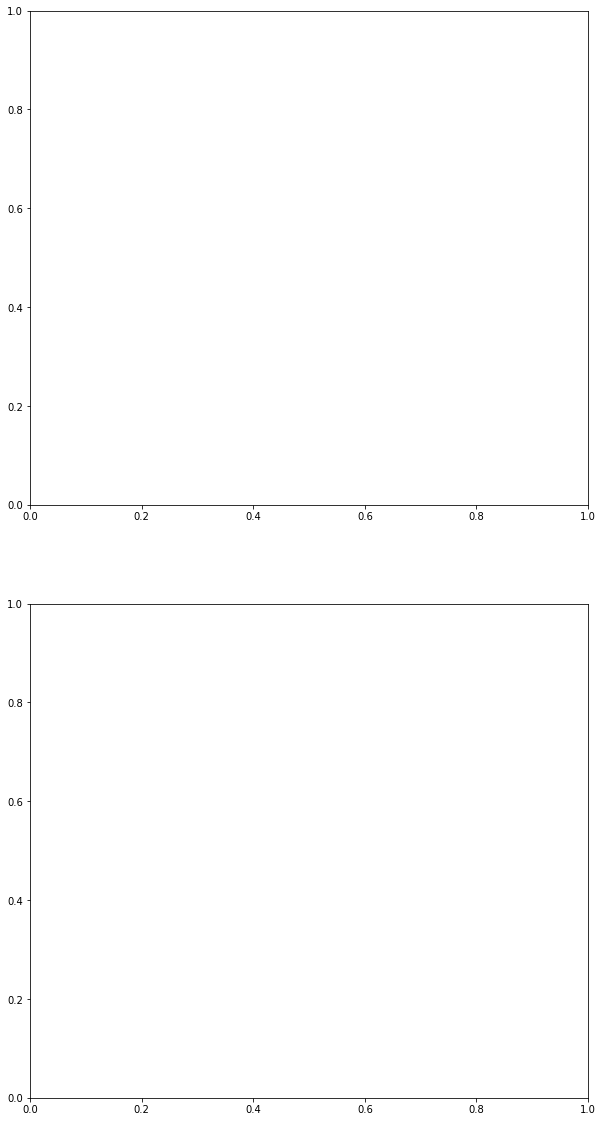

In [207]:
# plotting from multiple x array
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,20))
for i in range(3):
    y_fit = chi_dataset(out.params, i, x[i])
    ax1.plot(x[i], data[i].real, 'o', x[i], y_fit.real, '-')
    ax2.plot(x[i], data[i].imag, 'd', x[i], y_fit.imag, '--')
plt.show()

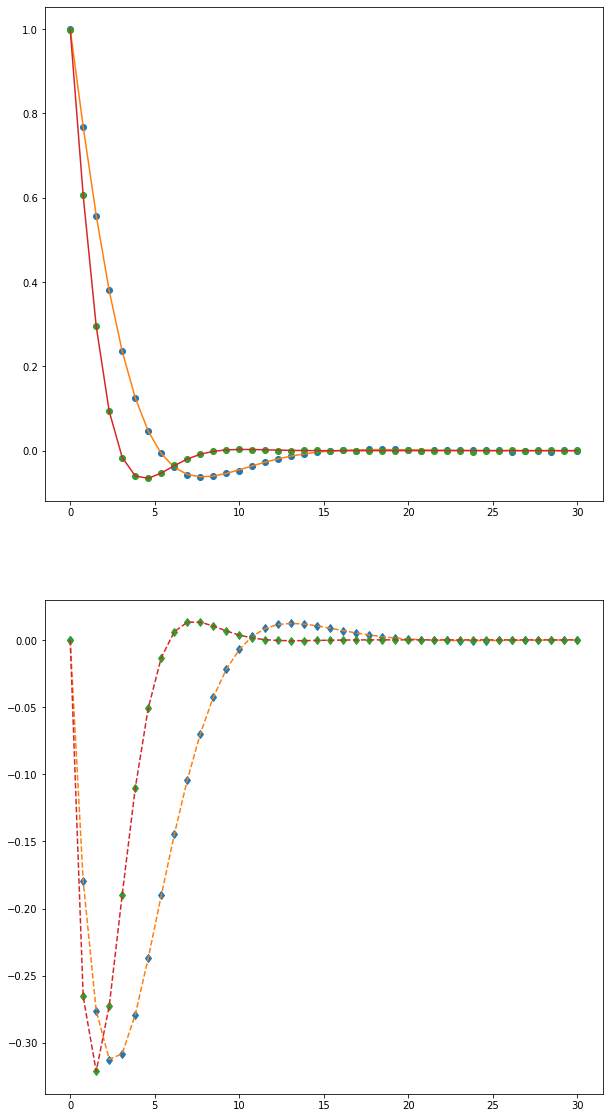

In [211]:
# plotting from single x array
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,20))
for i in range(2):
    y_fit = chi_dataset(out.params, i, x)
    ax1.plot(x, data[i].real, 'o', x, y_fit.real, '-')
    ax2.plot(x, data[i].imag, 'd', x, y_fit.imag, '--')
plt.show()

In [139]:
def objective_test(params, x, data, func):
    """Calculate total residual for fits of Gaussians to several data sets."""
    ndata = data.shape[0]
    resid = 0.0*data[:]

    resid_c = []
    # make residual per data set
    for i in range(ndata):
        resid[i, :] = data[i, :] - func(params, i, x)
        if resid[i].dtype == np.complex:
            resid_c.append(resid[i].ravel().view(np.float))
#         print(np.shape(resid))
    # now flatten this to a 1D array, as minimize() needs
    resid_c = np.array(resid_c)
    return resid_c.flatten()

In [140]:
objective_test(fit_params, x, data, chi_dataset)

array([-5.73898209e-04,  0.00000000e+00, -1.12166673e-01, -7.81451326e-02,
       -2.06468526e-01, -9.73580178e-02, -2.74019682e-01, -7.74544680e-02,
       -3.15180838e-01, -3.48838216e-02, -3.32277947e-01,  1.75758945e-02,
       -3.26719165e-01,  7.06718688e-02, -3.03313807e-01,  1.18263099e-01,
       -2.67777756e-01,  1.56777281e-01, -2.29401679e-01,  1.84635009e-01,
       -1.83340327e-01,  2.01704625e-01, -1.39882498e-01,  2.08824575e-01,
       -9.68713196e-02,  2.07410402e-01, -6.30369897e-02,  1.99149765e-01,
       -2.97659487e-02,  1.85779916e-01, -3.09651972e-03,  1.68937030e-01,
        1.88956923e-02,  1.50064492e-01,  3.43677375e-02,  1.30366920e-01,
        4.68326860e-02,  1.10797667e-01,  5.44088267e-02,  9.20691665e-02,
        5.90998048e-02,  7.46774160e-02,  6.01836489e-02,  5.89338643e-02,
        5.55836931e-02,  4.49997660e-02,  5.75602248e-02,  3.29196224e-02,
        5.40755194e-02,  2.26515948e-02,  4.93306033e-02,  1.40937573e-02,
        4.30292405e-02,  

In [142]:
objective_single(fit_params, x, data) - objective_test(fit_params, x, data, chi_dataset)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [143]:
fit_params.items()

odict_items([('ld_1', <Parameter 'ld_1', 20, bounds=[0.0:200]>), ('tg_1', <Parameter 'tg_1', 3, bounds=[0.01:100.0]>), ('f_1', <Parameter 'f_1', value=1 (fixed), bounds=[-inf:inf]>), ('ld_2', <Parameter 'ld_2', 20, bounds=[0.0:200]>), ('tg_2', <Parameter 'tg_2', 3, bounds=[0.01:100.0]>), ('f_2', <Parameter 'f_2', value=2 (fixed), bounds=[-inf:inf]>), ('ld_3', <Parameter 'ld_3', 20, bounds=[0.0:200]>), ('tg_3', <Parameter 'tg_3', 3, bounds=[0.01:100.0]>), ('f_3', <Parameter 'f_3', value=3 (fixed), bounds=[-inf:inf]>)])

In [149]:
import sys
import inspect

In [146]:
if sys.version_info >(3,4):
    print('yesy')

yesy


In [147]:
sys.version_info

sys.version_info(major=3, minor=6, micro=10, releaselevel='final', serial=0)

In [ ]:
def test_func(x, a, b ,c):
    def argnames():
        

In [148]:
hasattr(chi, 'argnames')

False

In [150]:
inspect.signature(chi)

<Signature (x, ld, tg, f)>

In [161]:
pos_args = []
kw_args = {}
keywords_ = None
sig = inspect.signature(chi)

for fnam, fpar in sig.parameters.items():
    if fpar.kind == fpar.POSITIONAL_OR_KEYWORD:
        if fpar.default == fpar.empty:
            pos_args.append(fnam)
        else:
            kw_args[fnam] = fpar.default
    elif fpar.kind == fpar.VAR_POSITIONAL:
        raise ValueError("varargs '*%s' is not supported" % fnam)

In [204]:
pos_args[1:]

['ld', 'tg', 'f']

In [160]:
ld = params['ld_%i' % (i+1)]

inspect._empty

In [164]:
pos_args[1]

'ld'

In [169]:
fit_params[pos_args[1] + '_%i' % (i+1)]

<Parameter 'ld_2', 20, bounds=[0.0:200]>

In [191]:
dum_params

name,value,initial value,min,max,vary
ld_1,-inf,None,-inf,inf,True
tg_1,-inf,None,-inf,inf,True
f_1,-inf,None,-inf,inf,True
ld_2,-inf,None,-inf,inf,True
tg_2,-inf,None,-inf,inf,True
f_2,-inf,None,-inf,inf,True


In [203]:
n_params = len(pos_args[1:])
n_dat = data.shape[0]

dum_params = Parameters()
for i in np.arange(n_dat):
    for j, p_name in enumerate(pos_args[1:]):
        print(p_name + '_%i' % (i+1))
        # 
        if flag == 2:
            dum_params.add(p_name + '_%i' % (i+1), value=initial_values[i+j],
                           vary=vary_params[i+j], min=bounds[i+j][0],
                           max=bounds[i+j][1])
        elif flag ==1:
            dum_params.add(p_name + '_%i' % (i+1), value=initial_values[j],
                           vary=vary_params[j], min=bounds[j][0],
                           max=bounds[j][1])
        else:
            dum_params.add(p_name + '_%i' % (i+1))
        
dum_params

ld_1
tg_1
f_1
ld_2
tg_2
f_2


name,value,initial value,min,max,vary
ld_1,15.0000000,15,0.00000000,inf,True
tg_1,0.10000000,0.1,0.00000000,inf,True
f_1,2.00000000,2,0.00000000,inf,False
ld_2,15.0000000,15,0.00000000,inf,True
tg_2,0.10000000,0.1,0.00000000,inf,True
f_2,2.00000000,2,0.00000000,inf,False


In [201]:
initial_values = [15, .1, 2]
vary_params = [True, True, False]
bounds = [(0, None), (0, None), (0, None)]

flag = 0
lens = [len(initial_values), len(vary_params), len(bounds)]
if all(x == n_params * n_dat for x in lens):
    print('Individual parameters')
    flag = 2
elif all (x == n_params for x in lens):
    print('One set of parameters')
    flag =1
else:
    print('Inadequate number of initial values, bounds, or parameter variability arguments')

One set of parameters


In [184]:
lens = [len(initial_values), len(vary_params), len(bounds)]
all(x == n_params for x in lens)

True

In [247]:
def dum_func(x, a, b, c):
    print(a,b,c)
    print(type(x))
    print(type(a), type(b), type(c))
    return np.exp(-x/a + b) + c
    

In [261]:
def func_dataset(params, i, x, func):
    """Calculate Gaussian lineshape from parameters for data set."""

    args = []
    for a in params:
        if a.endswith(str(i+1)):
            args.append(params[a])
#             print(a)
    return func(x, *args)

In [262]:
def objective_func(params, x, data, func):
    """Calculate total residual for fits of Gaussians to several data sets."""
    ndata = data.shape[0]
    resid = 0.0*data[:]

    resid_c = []
    # make residual per data set
    for i in range(ndata):
#         print(resid[i].shape)
        resid[i] = data[i] - func_dataset(params, i, x[i], func)
        if resid[i].dtype == np.complex:
            resid_c.append(resid[i].ravel().view(np.float))
#         print(np.shape(resid))
    # now flatten this to a 1D array, as minimize() needs
    resid_c = np.array(resid_c)
    return np.concatenate(resid_c).ravel()

In [276]:
func_dataset(fit_params, 0, x[0], chi)
# objective_func(fit_params, x, data, chi)
minimize(objective_func, fit_params, args=(x, data, chi))